# init_W（重みの初期値）を、重みの可視化から理解する

重みの初期値の分布を変化させると、どう変化するか？
初期値の分布として、

1. lecun_uniform: input数の平方根でスケーリングした一様分布 (LeCun 98)
2. glorot_normal: fan_in + fan_outでスケーリングした正規分布 (Glorot 2010)
3. he_normal: fan_inでスケーリングした正規分布 (He et al., 2014)
4. 自作の正規分布（stdの値を小さくセット）
5. 全部0

の場合を試し、学習回数ごとの重みの分布を調査した。
具体的には、隠れ層5つのモデルを学習し、学習前、epoch(学習数)=1, 3, 10回時点での、各層の重みの分布をヒストグラムにしてプロットし比較した。

In [3]:
# Kerasで必要なものをimport
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(111)

Using TensorFlow backend.


In [13]:
# データを用意＆加工
size_img = 28
n_label = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 1, size_img, size_img).astype('float32') / 255.
X_test = X_test.reshape(-1, 1, size_img, size_img).astype('float32') / 255.
Y_train = np_utils.to_categorical(y_train, n_label)
Y_test = np_utils.to_categorical(y_test, n_label)

# flatten the input images
shape_org = X_train.shape
X_train = X_train.reshape(-1, size_img * size_img)
X_test = X_test.reshape(-1, size_img * size_img)
print('transform X_train shape: %s -> %s' % (shape_org, X_train.shape))

# 学習ごとの重みの変化をみたいので、一度の学習サンプルを減らす
n_sample = 1000
X_train3 = X_train[:n_sample]
Y_train3 = Y_train[:n_sample]

transform X_train shape: (60000, 1, 28, 28) -> (60000, 784)


In [19]:
# 与えられたkerasのmodelから重みを抜き出す
def get_weights(model):
    weights, activations = [], []
    for layer in model.layers:
        if layer.name.startswith('dense_'):
            weights.append(layer.get_weights()[0])
    return weights


# モデルの構築
def construct_model(init_w):
    model = Sequential()
    model.add(Dense(100, input_dim=X_train3.shape[1], init=init_w))
    model.add(Activation('relu'))
    model.add(Dense(100, init=init_w))
    model.add(Activation('relu'))
    model.add(Dense(100, init=init_w))
    model.add(Activation('relu'))
    model.add(Dense(100, init=init_w))
    model.add(Activation('relu'))
    model.add(Dense(100, init=init_w))
    model.add(Activation('relu'))
    model.add(Dense(n_label, init=init_w))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

## 1. init_w = LeCun 98
初期値が一様な分布

Epoch 1/1
1000/1000 [==============================] - 0s - loss: 1.9155 - acc: 0.3550     
Epoch 1/2
1000/1000 [==============================] - 0s - loss: 0.6961 - acc: 0.7920     
Epoch 2/2
1000/1000 [==============================] - 0s - loss: 0.4127 - acc: 0.8790     
Epoch 1/7
1000/1000 [==============================] - 0s - loss: 0.2652 - acc: 0.9150     
Epoch 2/7
1000/1000 [==============================] - 0s - loss: 0.2052 - acc: 0.9360     
Epoch 3/7
1000/1000 [==============================] - 0s - loss: 0.1137 - acc: 0.9720     
Epoch 4/7
1000/1000 [==============================] - 0s - loss: 0.0566 - acc: 0.9890     
Epoch 5/7
1000/1000 [==============================] - 0s - loss: 0.0318 - acc: 0.9970     
Epoch 6/7
1000/1000 [==============================] - 0s - loss: 0.0212 - acc: 0.9970     
Epoch 7/7
1000/1000 [==============================] - 0s - loss: 0.0133 - acc: 0.9990     

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
n

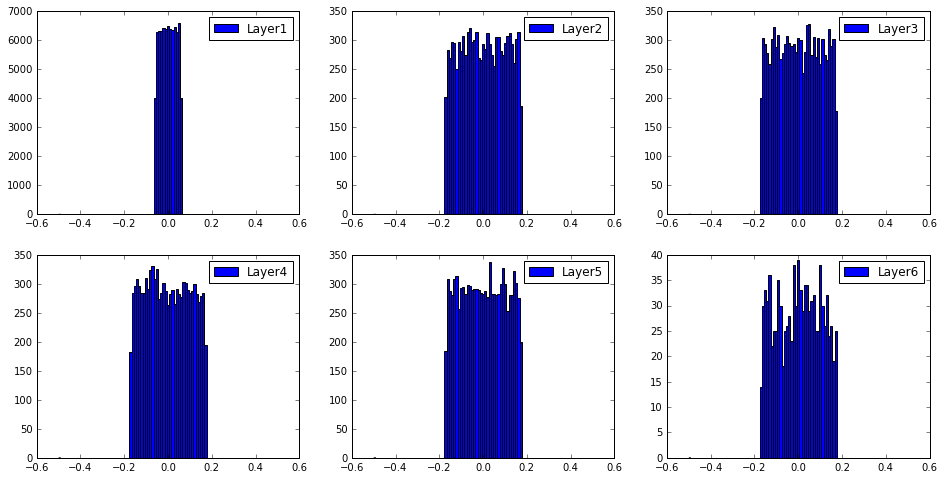


ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
n_epoch: 1
ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


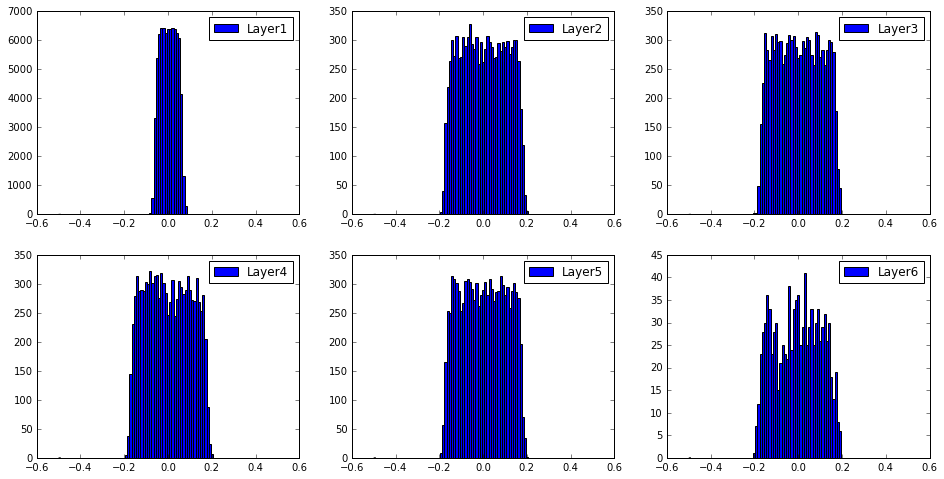


ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
n_epoch: 3
ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


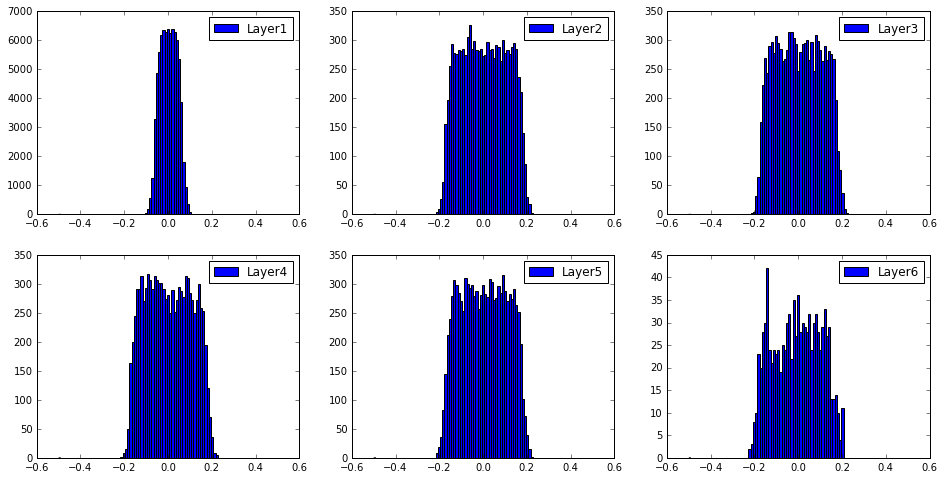


ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
n_epoch: 10
ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


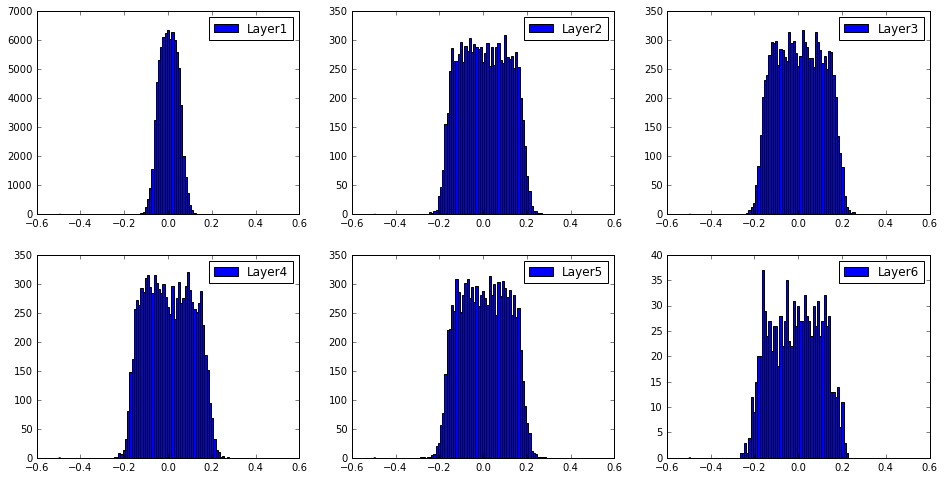

 9984/10000 [============================>.] - ETA: 0s
Test accuracy 0.883


In [26]:
model = construct_model('lecun_uniform')
n_epochs = [1, 2, 7]

# n_epochsにある値ごとに、その時点での重みを取得
log_weights = []
log_weights.append(get_weights(model))
for n in n_epochs:
    model.fit(X_train3, Y_train3, batch_size=30, nb_epoch=n)
    log_weights.append(get_weights(model))

# 上記で得た重みの分布を各層ごとにヒストグラムにしてプロット
n_epochs = np.array([0] + n_epochs).cumsum()
for weights, n in zip(log_weights, n_epochs):
    plt.figure(figsize=(16, 8))
    print('\n' + 'o' * 77)
    print('n_epoch: %d' % n)
    print('o' * 77)
    for i, w in enumerate(weights, 1):
            plt.subplot(2, 3, i)
            plt.hist(w.flatten(), bins=np.linspace(-0.5, 0.5, 100),  label=['Layer%d' % i])
            plt.legend()
    plt.show()

# Test dataの精度
v = model.evaluate(X_test, Y_test)
print('\nTest accuracy %.3f' % v[1])

### 考察

上図は、各layer間の重み全ての値をヒストグラムにしたもの。学習回数(n_epoch)=0, 1, 3, 10のときでヒストグラムをとり、重みの分布の変化も可視化した. 学習回数=0のときは、初期分布が見ている。この場合は、uniformなので、ある一定の幅でuniformな分布。学習回数が増えると、広がりが見えてくる。ただし、そこまで劇的に値が変化するわけではない。

## 2. init_w = Glorot 2010
fan_in + fan_outでスケーリングした正規分布 (Glorot 2010)

Epoch 1/1
1000/1000 [==============================] - 0s - loss: 1.8708 - acc: 0.3890     
Epoch 1/2
1000/1000 [==============================] - 0s - loss: 0.7521 - acc: 0.7630     
Epoch 2/2
1000/1000 [==============================] - 0s - loss: 0.4393 - acc: 0.8660     
Epoch 1/7
1000/1000 [==============================] - 0s - loss: 0.2736 - acc: 0.9170     
Epoch 2/7
1000/1000 [==============================] - 0s - loss: 0.1812 - acc: 0.9500     
Epoch 3/7
1000/1000 [==============================] - 0s - loss: 0.1324 - acc: 0.9640     
Epoch 4/7
1000/1000 [==============================] - 0s - loss: 0.0974 - acc: 0.9740     
Epoch 5/7
1000/1000 [==============================] - 0s - loss: 0.0599 - acc: 0.9870     
Epoch 6/7
1000/1000 [==============================] - 0s - loss: 0.0319 - acc: 0.9950     
Epoch 7/7
1000/1000 [==============================] - 0s - loss: 0.0168 - acc: 0.9970     

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
n

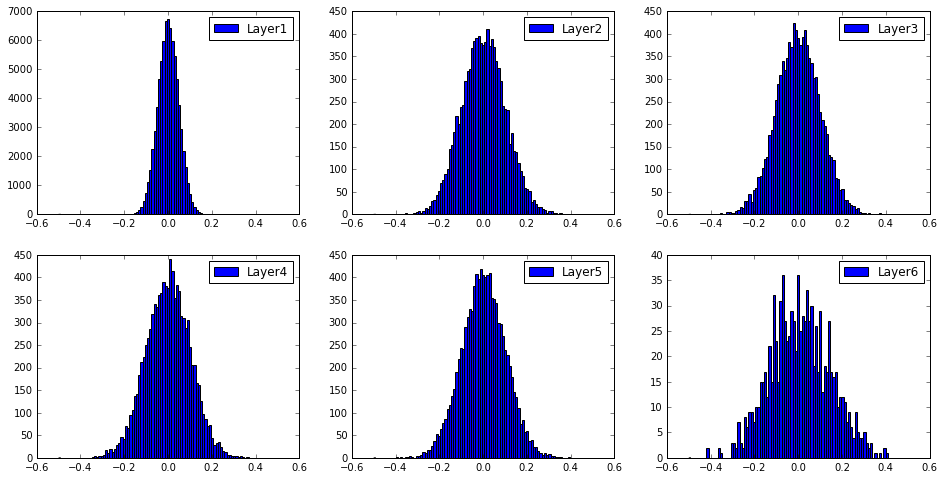


ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
n_epoch: 1
ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


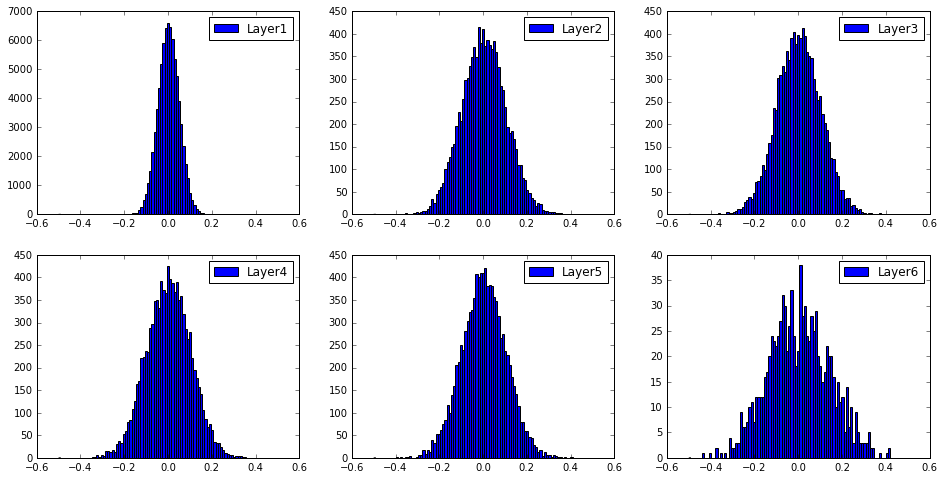


ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
n_epoch: 3
ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


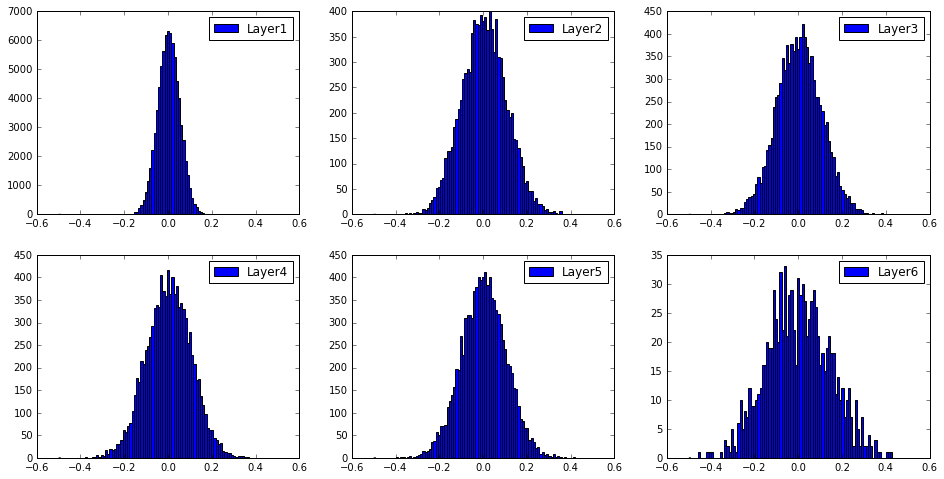


ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
n_epoch: 10
ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


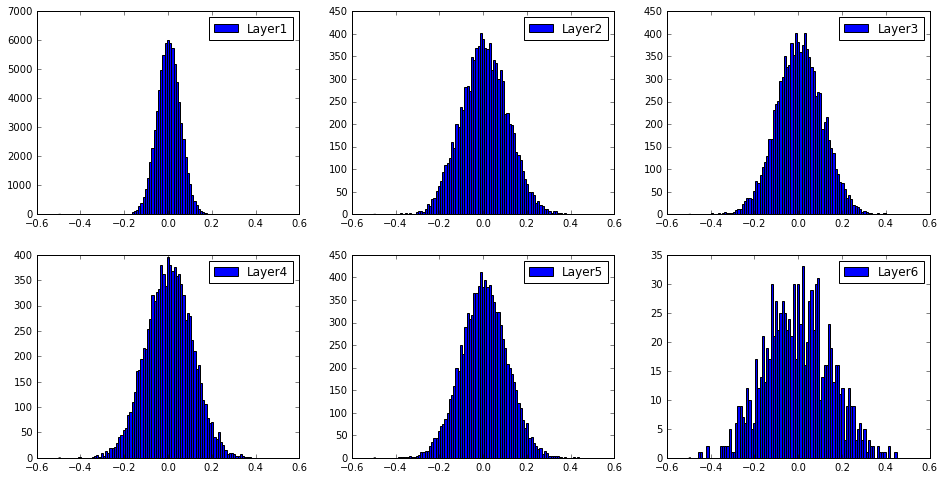

 9952/10000 [============================>.] - ETA: 0s
Test accuracy 0.883


In [21]:
model = construct_model('glorot_normal')
n_epochs = [1, 2, 7]

log_weights = []
log_weights.append(get_weights(model))
for n in n_epochs:
    model.fit(X_train3, Y_train3, batch_size=30, nb_epoch=n)
    log_weights.append(get_weights(model))

n_epochs = np.array([0] + n_epochs).cumsum()
for weights, n in zip(log_weights, n_epochs):
    plt.figure(figsize=(16, 8))
    print('\n' + 'o' * 77)
    print('n_epoch: %d' % n)
    print('o' * 77)
    for i, w in enumerate(weights, 1):
            plt.subplot(2, 3, i)
            plt.hist(w.flatten(), bins=np.linspace(-0.5, 0.5, 100),  label=['Layer%d' % i])
            plt.legend()
    plt.show()

# Test dataの精度
v = model.evaluate(X_test, Y_test)
print('\nTest accuracy %.3f' % v[1])

### 考察

学習回数が増えると、広がりが見えてくるのは１と同じ。初期分布がガウシアン分布であるだけ、より自然に広がっているには見える。ただし正解率に大きな違いはない。

## 3. init_w = He et al., 2014
fan_inでスケーリングした正規分布 (He et al., 2014)

Epoch 1/1
1000/1000 [==============================] - 0s - loss: 1.5673 - acc: 0.4940     
Epoch 1/2
1000/1000 [==============================] - 0s - loss: 0.5222 - acc: 0.8380     
Epoch 2/2
1000/1000 [==============================] - 0s - loss: 0.3138 - acc: 0.9110     
Epoch 1/7
1000/1000 [==============================] - 0s - loss: 0.2033 - acc: 0.9450     
Epoch 2/7
1000/1000 [==============================] - 0s - loss: 0.1097 - acc: 0.9790     
Epoch 3/7
1000/1000 [==============================] - 0s - loss: 0.0705 - acc: 0.9810     
Epoch 4/7
1000/1000 [==============================] - 0s - loss: 0.0436 - acc: 0.9940     
Epoch 5/7
1000/1000 [==============================] - 0s - loss: 0.0361 - acc: 0.9910     
Epoch 6/7
1000/1000 [==============================] - 0s - loss: 0.0204 - acc: 0.9950     
Epoch 7/7
1000/1000 [==============================] - 0s - loss: 0.0126 - acc: 0.9980     

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
n

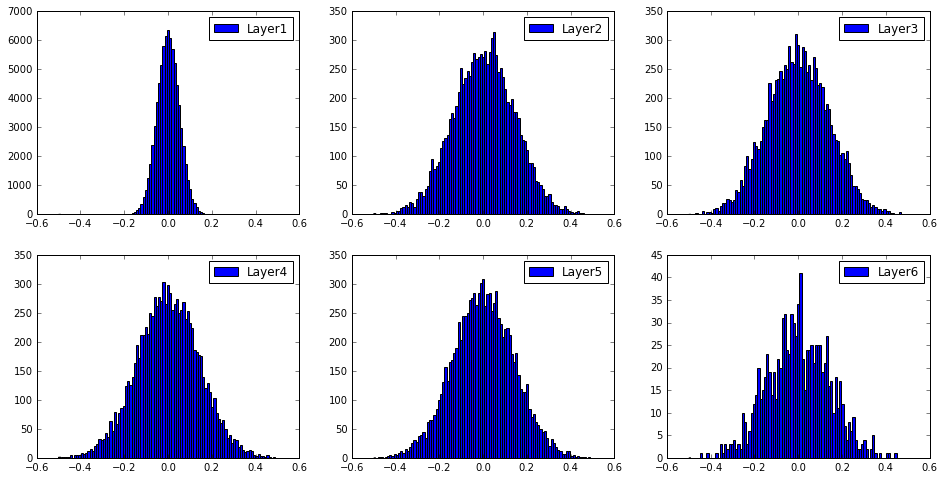


ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
n_epoch: 1
ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


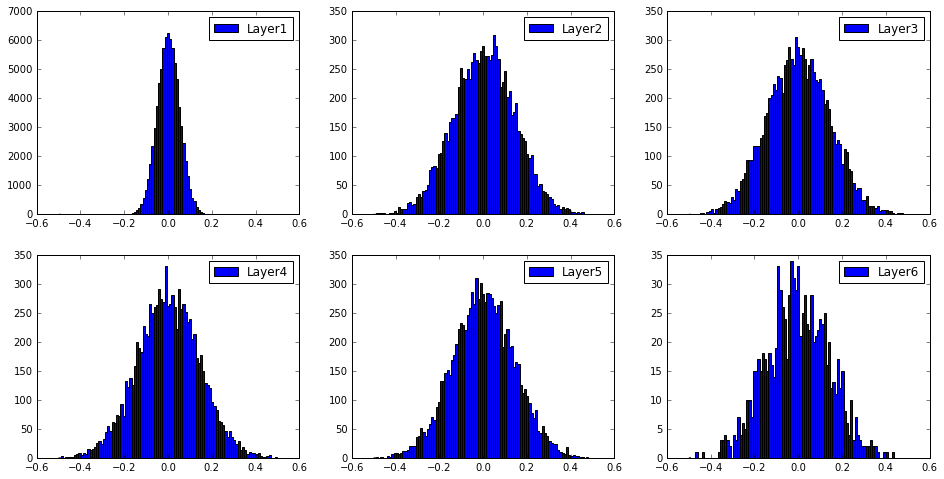


ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
n_epoch: 3
ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


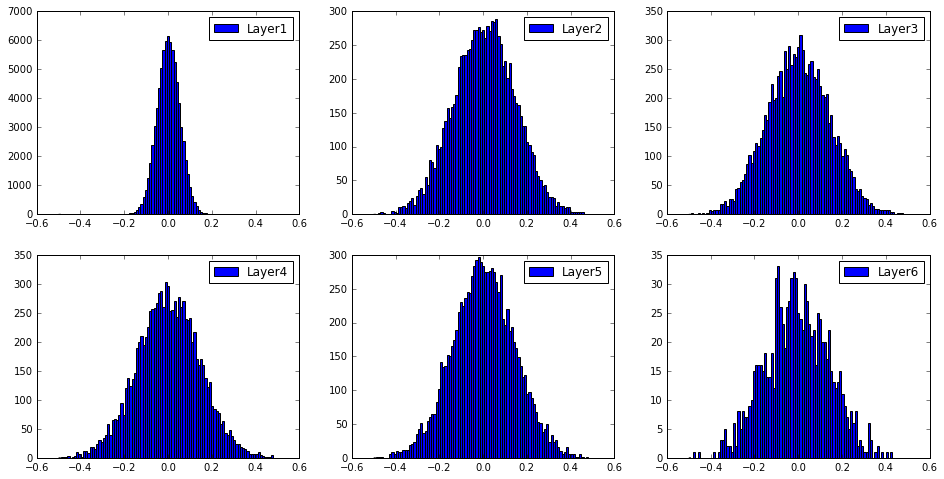


ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
n_epoch: 10
ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


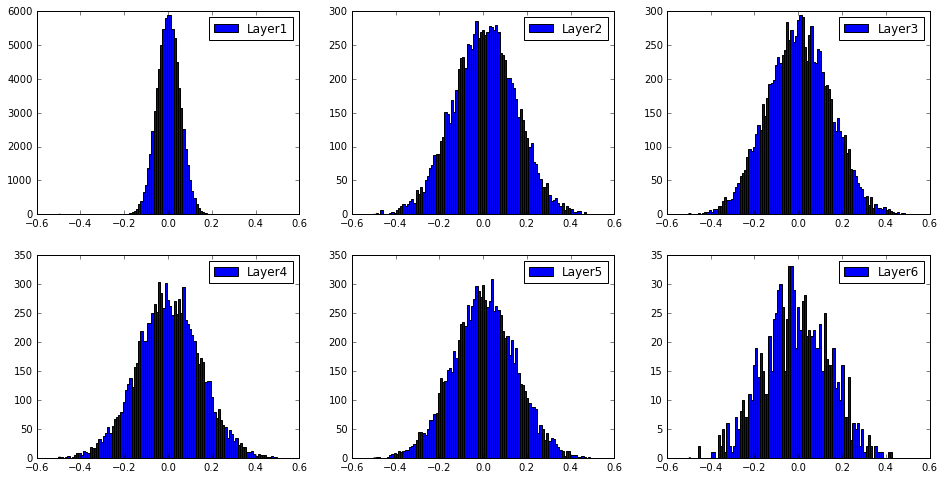

10000/10000 [==============================] - 1s     

Test accuracy 0.885


In [22]:
model = construct_model('he_normal')
n_epochs = [1, 2, 7]

log_weights = []
log_weights.append(get_weights(model))
for n in n_epochs:
    model.fit(X_train3, Y_train3, batch_size=30, nb_epoch=n)
    log_weights.append(get_weights(model))

n_epochs = np.array([0] + n_epochs).cumsum()
for weights, n in zip(log_weights, n_epochs):
    plt.figure(figsize=(16, 8))
    print('\n' + 'o' * 77)
    print('n_epoch: %d' % n)
    print('o' * 77)
    for i, w in enumerate(weights, 1):
            plt.subplot(2, 3, i)
            plt.hist(w.flatten(), bins=np.linspace(-0.5, 0.5, 100),  label=['Layer%d' % i])
            plt.legend()
    plt.show()

# Test dataの精度
v = model.evaluate(X_test, Y_test)
print('\nTest accuracy %.3f' % v[1])

### 考察

2との違いはわかりづらいが、初期分布（学習回数0回）と学習10回の重みの分布の大きさがほとんど同じであることは重要。つまり初期分布の広がりは、すでに学習済みと同じ広がりを持っているということ。初期分布に適切な広がりをもつ事は重要（下記4, 5参照）なので、このモデルではこの分布が一番良いように思える。ただし、1,2,3と正解率に違いは見えないので、そこまでクリティカルな違いではないのだろう。

## 4. init_w = 自作（広がりの小さいガウシアン分布）

自作ガウシアン。その広がり（標準偏差）stdは、 1e-2にセット。上の初期分布のstdは~0.1なので、一桁ほど小さい。

Epoch 1/1
1000/1000 [==============================] - 0s - loss: 2.3027 - acc: 0.0850     
Epoch 1/2
1000/1000 [==============================] - 0s - loss: 2.1624 - acc: 0.1740     
Epoch 2/2
1000/1000 [==============================] - 0s - loss: 1.9316 - acc: 0.2020     
Epoch 1/7
1000/1000 [==============================] - 0s - loss: 1.8138 - acc: 0.1960     
Epoch 2/7
1000/1000 [==============================] - 0s - loss: 1.7441 - acc: 0.2180     
Epoch 3/7
1000/1000 [==============================] - 0s - loss: 1.7137 - acc: 0.1990     
Epoch 4/7
1000/1000 [==============================] - 0s - loss: 1.6868 - acc: 0.2030     
Epoch 5/7
1000/1000 [==============================] - 0s - loss: 1.6353 - acc: 0.2200     
Epoch 6/7
1000/1000 [==============================] - 0s - loss: 1.5848 - acc: 0.2150     
Epoch 7/7
1000/1000 [==============================] - 0s - loss: 1.5865 - acc: 0.2360     

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
n

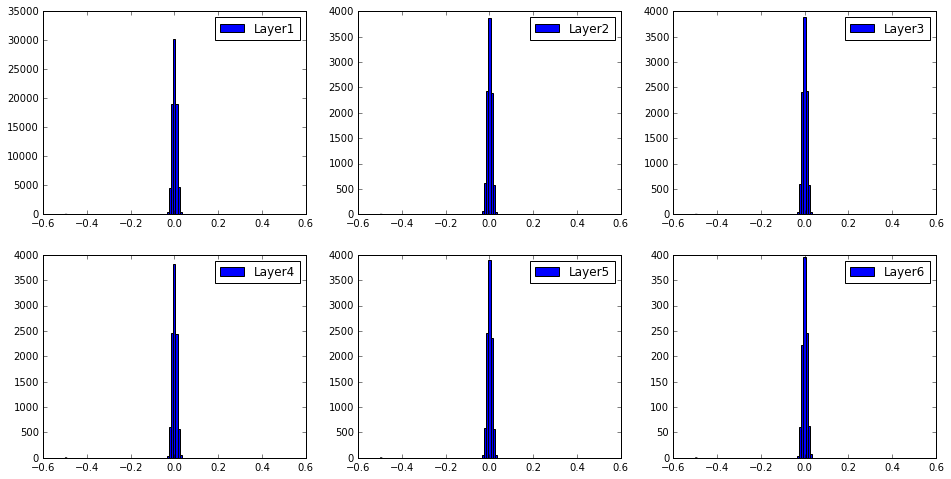


ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
n_epoch: 1
ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


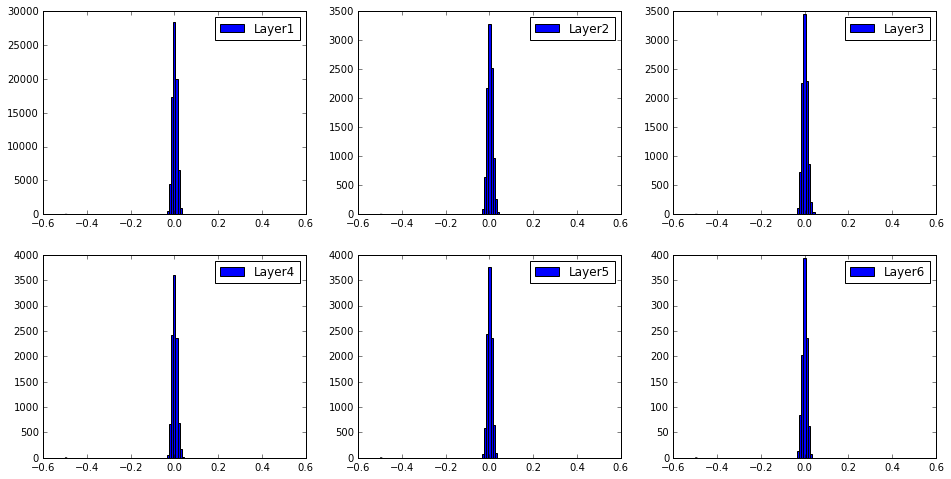


ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
n_epoch: 3
ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


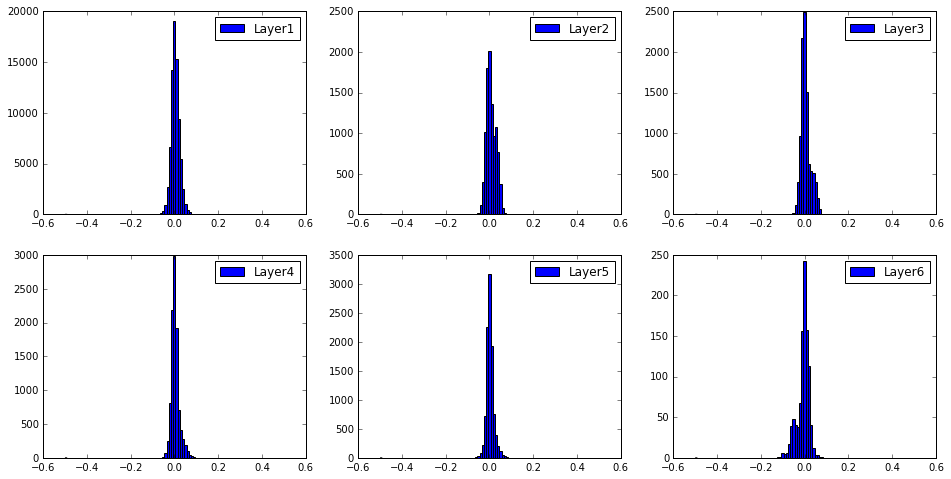


ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
n_epoch: 10
ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


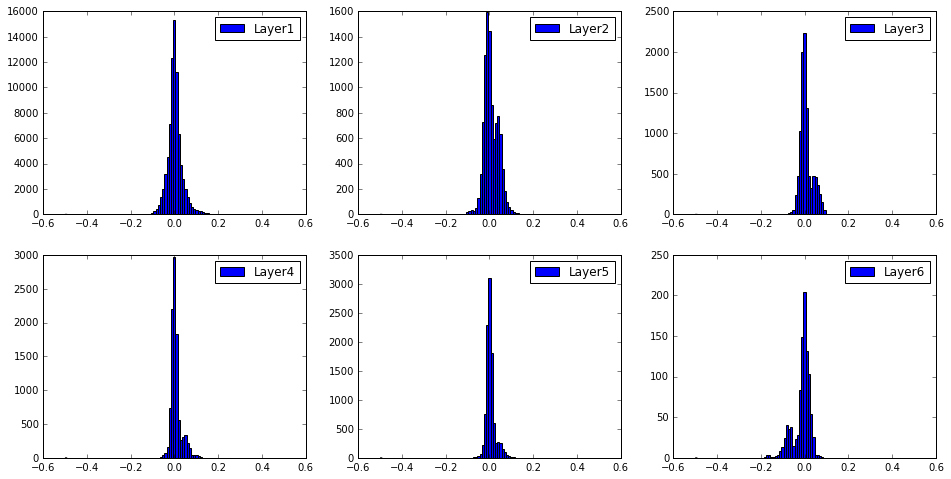

 9920/10000 [============================>.] - ETA: 0s
Test accuracy 0.219


In [24]:
from keras import initializations
def my_init(shape, name=None):
    return initializations.normal(shape, scale=1e-2, name=name)

model = construct_model(my_init)
n_epochs = [1, 2, 7]

log_weights = []
log_weights.append(get_weights(model))
for n in n_epochs:
    model.fit(X_train3, Y_train3, batch_size=30, nb_epoch=n)
    log_weights.append(get_weights(model))

n_epochs = np.array([0] + n_epochs).cumsum()
for weights, n in zip(log_weights, n_epochs):
    plt.figure(figsize=(16, 8))
    print('\n' + 'o' * 77)
    print('n_epoch: %d' % n)
    print('o' * 77)
    for i, w in enumerate(weights, 1):
            plt.subplot(2, 3, i)
            plt.hist(w.flatten(), bins=np.linspace(-0.5, 0.5, 100),  label=['Layer%d' % i])
            plt.legend()
    plt.show()

# Test dataの精度
v = model.evaluate(X_test, Y_test)
print('\nTest accuracy %.3f' % v[1])

### 考察

明らかにこれまでの分布とは異なるのがわかる。実際、正解率も~88% -> ~22%と大幅な悪化。学習回数が増えるごとに重みは広がりをみせるが、モデルを適切に学習させるには小さすぎる。もっと多くの学習回数を重ねれば正解率もあがるかもしれないが、明らかに初期分布の幅が小さすぎだろう。学習した重みの分布が非対称なのも面白い。

## 5. init_w = 自作 (重み0)

重みが全て0だと学習しないはず。これはただの遊びです。

Epoch 1/1
1000/1000 [==============================] - 0s - loss: 2.3027 - acc: 0.0890     
Epoch 1/2
1000/1000 [==============================] - 0s - loss: 2.3022 - acc: 0.1010     
Epoch 2/2
1000/1000 [==============================] - 0s - loss: 2.3017 - acc: 0.1130     
Epoch 1/7
1000/1000 [==============================] - 0s - loss: 2.3014 - acc: 0.1130     
Epoch 2/7
1000/1000 [==============================] - 0s - loss: 2.3010 - acc: 0.1160     
Epoch 3/7
1000/1000 [==============================] - 0s - loss: 2.3007 - acc: 0.1060     
Epoch 4/7
1000/1000 [==============================] - 0s - loss: 2.3004 - acc: 0.1160     
Epoch 5/7
1000/1000 [==============================] - 0s - loss: 2.3002 - acc: 0.1160     
Epoch 6/7
1000/1000 [==============================] - 0s - loss: 2.3000 - acc: 0.1160     
Epoch 7/7
1000/1000 [==============================] - 0s - loss: 2.2997 - acc: 0.1160     

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
n

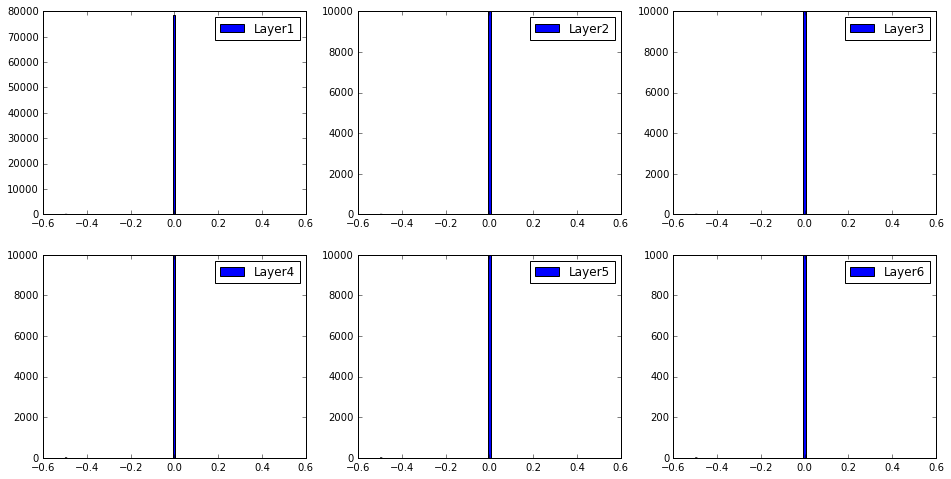


ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
n_epoch: 1
ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


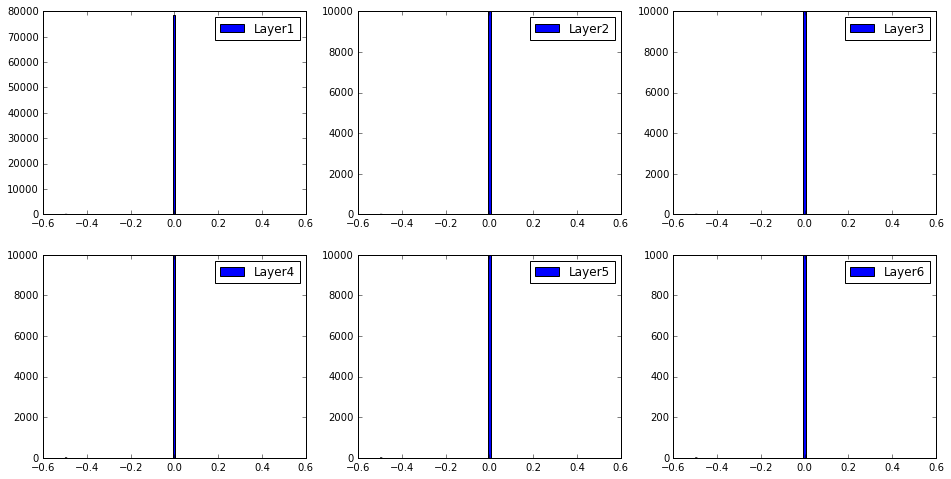


ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
n_epoch: 3
ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


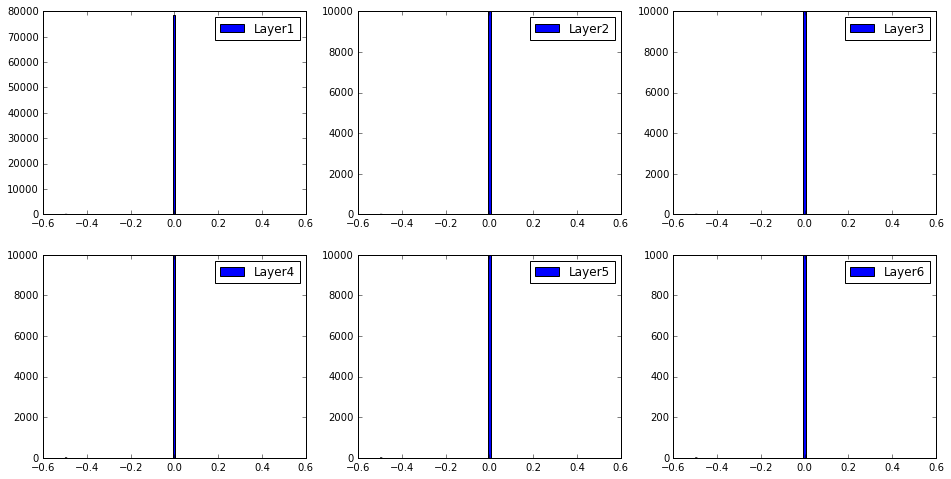


ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
n_epoch: 10
ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


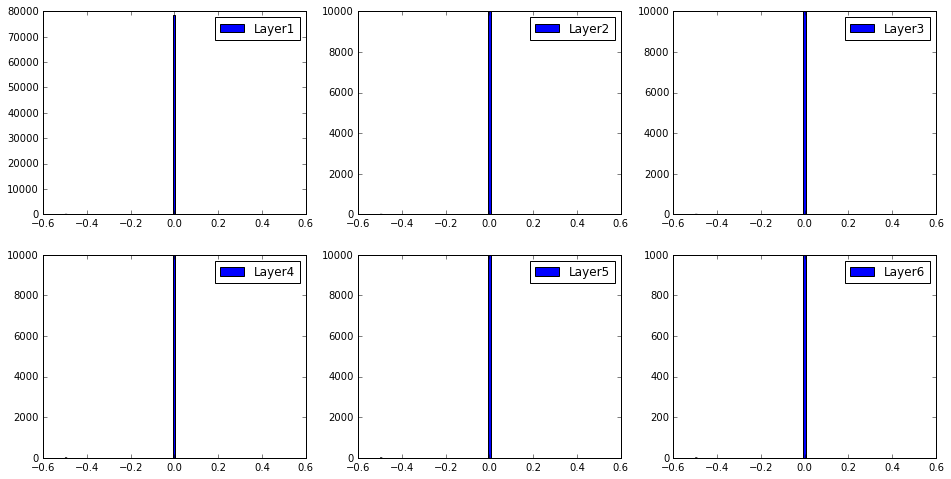

10000/10000 [==============================] - 1s     

Test accuracy 0.114


In [25]:
from keras import initializations
def my_init(shape, name=None):
    return initializations.normal(shape, scale=0.0, name=name)

model = construct_model(my_init)
n_epochs = [1, 2, 7]

log_weights = []
log_weights.append(get_weights(model))
for n in n_epochs:
    model.fit(X_train3, Y_train3, batch_size=30, nb_epoch=n)
    log_weights.append(get_weights(model))

n_epochs = np.array([0] + n_epochs).cumsum()
for weights, n in zip(log_weights, n_epochs):
    plt.figure(figsize=(16, 8))
    print('\n' + 'o' * 77)
    print('n_epoch: %d' % n)
    print('o' * 77)
    for i, w in enumerate(weights, 1):
            plt.subplot(2, 3, i)
            plt.hist(w.flatten(), bins=np.linspace(-0.5, 0.5, 100),  label=['Layer%d' % i])
            plt.legend()
    plt.show()

# Test dataの精度
v = model.evaluate(X_test, Y_test)
print('\nTest accuracy %.3f' % v[1])

### 考察

たしかに全く学びませんね。人間こうはなりたくないものです。

## 考察（まとめ）

最初の3つの初期分布、(LeCun 98)、(Glorot 2010)、(He et al., 2014)は、実際によく使われる分布であり、どの場合でも正解率は高かった。ただし今回のモデルでは、学習回数が進むごとにガウシアン的に広がっているように見えるので、ガウシアン分布の方がよいかなとも思う（ただの直観で、理論的ではない）。4, 5のように、自作して明らかに小さい幅の初期分布すれば問題になるので、ある程度の広がりの初期分布が必要なのは間違いない。ただ、よく使われている初期分布を使えば、だいたい適切な範囲で初期分布を設定してくれるので、（収束するまでの学習回数に若干の違いはあるかもだが）そこまで神経質にならなくても良いと思われる。
